# 1.13b: Lattice Structure Search

**Goal:** Search for black holes and lattice-adjacent structure in any W matrix.

## Method

1. **Black holes**: Find tokens with identical vectors (all dimensions equal)
2. **Orthogonal neighbors**: Tokens differing by ±1 mantissa in exactly 1 dimension
3. **Diagonal neighbors**: Tokens differing by ±1 mantissa in 2+ dimensions

## Output Format

For each category, report:
- Number of tokens that participate
- Token IDs (explicit list)
- Boolean mask (N,) tensor
- Degree distribution (how many neighbors each token has)

## Constraints

- Only compare values with same sign (no zero crossings)
- Only compare values with same exponent (no exponent boundaries)
- Distance measured in mantissa units (1 = smallest representable difference)

## Parameters

Flexible tensor loading: specify file, key, and optional index for time-series data.

## Parameters

In [22]:
# Tensor to analyze
TENSOR_FILE = "../tensors/Lil_Gatsby/1.12a_training_data.safetensors"
TENSOR_KEY = "W"
TENSOR_INDEX = 0  # -1 = final, 0 = init, None = no indexing (load full tensor)

# Analysis parameters
MAX_EXAMPLES_PER_CATEGORY = 10  # How many example tokens to show in detail

## Imports

In [23]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

## Device Detection

In [24]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [25]:
# Load tensor
data = load_file(TENSOR_FILE)
W = data[TENSOR_KEY]

# Apply indexing if specified
if TENSOR_INDEX is not None:
    W = W[TENSOR_INDEX]
    index_desc = f"index {TENSOR_INDEX}"
else:
    index_desc = "(no indexing)"

print(f"✓ Loaded tensor from {Path(TENSOR_FILE).name}")
print(f"  Key: {TENSOR_KEY}")
print(f"  Index: {index_desc}")
print(f"  Shape: {W.shape}")
print(f"  Dtype: {W.dtype}")

n_vectors, n_dims = W.shape
print(f"\n✓ Analyzing {n_vectors:,} vectors in {n_dims:,} dimensions")

✓ Loaded tensor from 1.12a_training_data.safetensors
  Key: W
  Index: index 0
  Shape: torch.Size([128, 64])
  Dtype: torch.bfloat16

✓ Analyzing 128 vectors in 64 dimensions


## Helper Functions

In [26]:
def decode_bfloat16_components(values_bf16):
    """
    Decode bfloat16 values into sign, exponent, mantissa components.
    
    Args:
        values_bf16: torch.Tensor of bfloat16 values
    
    Returns:
        dict with 'signs', 'exponents', 'mantissas' as uint tensors
    """
    # Preserve exact bit pattern as unsigned integer
    values_uint16 = values_bf16.view(torch.int16).to(torch.int64) & 0xFFFF
    
    signs = (values_uint16 >> 15) & 0x1
    exponents = (values_uint16 >> 7) & 0xFF
    mantissas = values_uint16 & 0x7F
    
    return {
        'uint16': values_uint16,
        'signs': signs,
        'exponents': exponents,
        'mantissas': mantissas
    }

def find_dimension_differences(vec_a, vec_b):
    """
    Find dimensions where two vectors differ by exactly ±1 mantissa (same sign, same exp).
    
    Args:
        vec_a, vec_b: (D,) tensors of bfloat16 values
    
    Returns:
        list of dimension indices where vectors are single-mantissa neighbors
    """
    decoded_a = decode_bfloat16_components(vec_a)
    decoded_b = decode_bfloat16_components(vec_b)
    
    # Find dimensions where:
    # - Same sign
    # - Same exponent
    # - Mantissa differs by exactly 1
    
    same_sign = decoded_a['signs'] == decoded_b['signs']
    same_exp = decoded_a['exponents'] == decoded_b['exponents']
    mant_diff = (decoded_a['mantissas'] - decoded_b['mantissas']).abs()
    mant_diff_one = mant_diff == 1
    
    # All three conditions
    is_neighbor = same_sign & same_exp & mant_diff_one
    
    # Return dimension indices where condition is true
    neighbor_dims = is_neighbor.nonzero(as_tuple=True)[0].tolist()
    
    return neighbor_dims

print("✓ Helper functions defined")

✓ Helper functions defined


## Stage 1: Black Holes (Exact Equality)

In [27]:
print("\n" + "=" * 80)
print("STAGE 1: BLACK HOLES (EXACT VECTOR EQUALITY)")
print("=" * 80)
print()

black_hole_pairs = []

# Check all pairs for exact equality
print("Searching for exact vector equality...")
for i in range(n_vectors):
    if i % 20 == 0:
        print(f"  Progress: {i}/{n_vectors}", end='\r')
    for j in range(i + 1, n_vectors):
        if torch.equal(W[i], W[j]):
            black_hole_pairs.append((i, j))

print(f"\n\n✓ Search complete\n")

# Extract unique tokens that participate in black holes
black_hole_tokens = set()
for i, j in black_hole_pairs:
    black_hole_tokens.add(i)
    black_hole_tokens.add(j)

black_hole_tokens = sorted(black_hole_tokens)
black_hole_mask = torch.zeros(n_vectors, dtype=torch.bool)
if len(black_hole_tokens) > 0:
    black_hole_mask[black_hole_tokens] = True

# Compute degree (how many duplicates each token has)
black_hole_degrees = {}
for token in black_hole_tokens:
    degree = sum(1 for i, j in black_hole_pairs if i == token or j == token)
    black_hole_degrees[token] = degree

if len(black_hole_tokens) > 0:
    print(f"⚠️  Found {len(black_hole_tokens)} tokens participating in black holes!")
    print(f"    ({len(black_hole_pairs)} pairs total)\n")
    
    print(f"Token IDs: {black_hole_tokens}\n")
    
    # Show degree distribution
    print(f"Degree distribution (top {MAX_EXAMPLES_PER_CATEGORY}):")
    for token in sorted(black_hole_degrees.keys(), key=lambda t: -black_hole_degrees[t])[:MAX_EXAMPLES_PER_CATEGORY]:
        degree = black_hole_degrees[token]
        print(f"  Token {token:4d}: {degree} duplicate(s)")
    
    if len(black_hole_tokens) > MAX_EXAMPLES_PER_CATEGORY:
        print(f"  ... and {len(black_hole_tokens) - MAX_EXAMPLES_PER_CATEGORY} more")
    print()
else:
    print("✓ No black holes found. All vectors are distinct.\n")


STAGE 1: BLACK HOLES (EXACT VECTOR EQUALITY)

Searching for exact vector equality...
  Progress: 120/128

✓ Search complete

✓ No black holes found. All vectors are distinct.



## Stage 2: Orthogonal Neighbors (1 Dimension)

In [28]:
print("\n" + "=" * 80)
print("STAGE 2: ORTHOGONAL NEIGHBORS (differ by ±1 mantissa in exactly 1 dimension)")
print("=" * 80)
print()

orthogonal_pairs = []

# Check all pairs
print("Searching for orthogonal neighbors...")
for i in range(n_vectors):
    if i % 20 == 0:
        print(f"  Progress: {i}/{n_vectors}", end='\r')
    for j in range(i + 1, n_vectors):
        diff_dims = find_dimension_differences(W[i], W[j])
        
        # Orthogonal = exactly 1 dimension differs
        if len(diff_dims) == 1:
            orthogonal_pairs.append((i, j, diff_dims[0]))

print(f"\n\n✓ Search complete\n")

# Extract unique tokens
orthogonal_tokens = set()
for i, j, dim in orthogonal_pairs:
    orthogonal_tokens.add(i)
    orthogonal_tokens.add(j)

orthogonal_tokens = sorted(orthogonal_tokens)
orthogonal_mask = torch.zeros(n_vectors, dtype=torch.bool)
if len(orthogonal_tokens) > 0:
    orthogonal_mask[orthogonal_tokens] = True

# Compute degree (how many neighbors each token has)
orthogonal_degrees = {}
for token in orthogonal_tokens:
    degree = sum(1 for i, j, _ in orthogonal_pairs if i == token or j == token)
    orthogonal_degrees[token] = degree

if len(orthogonal_tokens) > 0:
    print(f"Found {len(orthogonal_tokens)} tokens with orthogonal neighbors!")
    print(f"  ({len(orthogonal_pairs)} pairs total)\n")
    
    print(f"Token IDs: {orthogonal_tokens}\n")
    
    # Show degree distribution
    print(f"Degree distribution (top {MAX_EXAMPLES_PER_CATEGORY}):")
    for token in sorted(orthogonal_degrees.keys(), key=lambda t: -orthogonal_degrees[t])[:MAX_EXAMPLES_PER_CATEGORY]:
        degree = orthogonal_degrees[token]
        print(f"  Token {token:4d}: {degree} orthogonal neighbor(s)")
    
    if len(orthogonal_tokens) > MAX_EXAMPLES_PER_CATEGORY:
        print(f"  ... and {len(orthogonal_tokens) - MAX_EXAMPLES_PER_CATEGORY} more")
    print()
    
    # Show which dimensions are most common
    dim_counts = Counter([dim for _, _, dim in orthogonal_pairs])
    print(f"Most common dimensions (top 10):")
    for dim, count in dim_counts.most_common(10):
        print(f"  Dimension {dim:3d}: {count:4d} pairs")
    print()
else:
    print("✓ No orthogonal neighbors found.\n")


STAGE 2: ORTHOGONAL NEIGHBORS (differ by ±1 mantissa in exactly 1 dimension)

Searching for orthogonal neighbors...
  Progress: 120/128

✓ Search complete

Found 128 tokens with orthogonal neighbors!
  (804 pairs total)

Token IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]

Degree distribution (top 10):
  Token   78: 23 orthogonal neighbor(s)
  Token   53: 21 orthogonal neighbor(s)
  Token   72: 21 orthogonal neighbor(s)
  Token   15: 20 orthogonal neighbor(s)
  Token   30: 20 orthogonal neighbor(s)
  Tok

## Stage 3: Diagonal Neighbors (2+ Dimensions)

In [29]:
print("\n" + "=" * 80)
print("STAGE 3: DIAGONAL NEIGHBORS (differ by ±1 mantissa in 2+ dimensions)")
print("=" * 80)
print()

diagonal_pairs = []

# Check all pairs
print("Searching for diagonal neighbors...")
for i in range(n_vectors):
    if i % 20 == 0:
        print(f"  Progress: {i}/{n_vectors}", end='\r')
    for j in range(i + 1, n_vectors):
        diff_dims = find_dimension_differences(W[i], W[j])
        
        # Diagonal = 2 or more dimensions differ
        if len(diff_dims) >= 2:
            diagonal_pairs.append((i, j, len(diff_dims)))

print(f"\n\n✓ Search complete\n")

# Extract unique tokens
diagonal_tokens = set()
for i, j, n_dims in diagonal_pairs:
    diagonal_tokens.add(i)
    diagonal_tokens.add(j)

diagonal_tokens = sorted(diagonal_tokens)
diagonal_mask = torch.zeros(n_vectors, dtype=torch.bool)
if len(diagonal_tokens) > 0:
    diagonal_mask[diagonal_tokens] = True

# Compute degree (how many neighbors each token has)
diagonal_degrees = {}
for token in diagonal_tokens:
    degree = sum(1 for i, j, _ in diagonal_pairs if i == token or j == token)
    diagonal_degrees[token] = degree

if len(diagonal_tokens) > 0:
    print(f"Found {len(diagonal_tokens)} tokens with diagonal neighbors!")
    print(f"  ({len(diagonal_pairs)} pairs total)\n")
    
    print(f"Token IDs: {diagonal_tokens}\n")
    
    # Show degree distribution
    print(f"Degree distribution (top {MAX_EXAMPLES_PER_CATEGORY}):")
    for token in sorted(diagonal_degrees.keys(), key=lambda t: -diagonal_degrees[t])[:MAX_EXAMPLES_PER_CATEGORY]:
        degree = diagonal_degrees[token]
        print(f"  Token {token:4d}: {degree} diagonal neighbor(s)")
    
    if len(diagonal_tokens) > MAX_EXAMPLES_PER_CATEGORY:
        print(f"  ... and {len(diagonal_tokens) - MAX_EXAMPLES_PER_CATEGORY} more")
    print()
    
    # Show distribution by number of dimensions
    n_dims_counts = Counter([n_dims for _, _, n_dims in diagonal_pairs])
    print(f"Distribution by number of differing dimensions:")
    for n_dims in sorted(n_dims_counts.keys())[:20]:  # Show first 20
        count = n_dims_counts[n_dims]
        pct = 100 * count / len(diagonal_pairs)
        print(f"  {n_dims:2d} dimensions: {count:6,} pairs ({pct:5.1f}%)")
    
    if len(n_dims_counts) > 20:
        print(f"  ... and {len(n_dims_counts) - 20} more categories")
    print()
else:
    print("✓ No diagonal neighbors found.\n")


STAGE 3: DIAGONAL NEIGHBORS (differ by ±1 mantissa in 2+ dimensions)

Searching for diagonal neighbors...
  Progress: 120/128

✓ Search complete

Found 66 tokens with diagonal neighbors!
  (47 pairs total)

Token IDs: [1, 3, 5, 8, 9, 10, 15, 17, 19, 20, 21, 22, 26, 27, 29, 31, 33, 35, 37, 39, 41, 42, 43, 49, 50, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 71, 73, 75, 77, 78, 79, 84, 85, 86, 87, 88, 91, 95, 96, 97, 98, 99, 104, 108, 110, 115, 116, 120, 121, 124, 125, 127]

Degree distribution (top 10):
  Token    8: 3 diagonal neighbor(s)
  Token   20: 3 diagonal neighbor(s)
  Token   60: 3 diagonal neighbor(s)
  Token   77: 3 diagonal neighbor(s)
  Token   79: 3 diagonal neighbor(s)
  Token   88: 3 diagonal neighbor(s)
  Token    3: 2 diagonal neighbor(s)
  Token    5: 2 diagonal neighbor(s)
  Token   19: 2 diagonal neighbor(s)
  Token   29: 2 diagonal neighbor(s)
  ... and 56 more

Distribution by number of differing dimensions:
   2 dimensions:     43 pairs ( 91.5%)
   3

## Summary

In [30]:
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print()

print(f"Analyzed: {n_vectors:,} vectors × {n_dims:,} dimensions")
print(f"Total pairs checked: {n_vectors * (n_vectors - 1) // 2:,}")
print()

print(f"Tokens participating in lattice structure:")
print(f"  Black holes (exact equality):     {len(black_hole_tokens):4,} tokens ({100*len(black_hole_tokens)/n_vectors:5.1f}%)")
print(f"  Orthogonal neighbors (1 dim):     {len(orthogonal_tokens):4,} tokens ({100*len(orthogonal_tokens)/n_vectors:5.1f}%)")
print(f"  Diagonal neighbors (2+ dims):     {len(diagonal_tokens):4,} tokens ({100*len(diagonal_tokens)/n_vectors:5.1f}%)")
print()

# Compute overlap
all_structured_tokens = set(black_hole_tokens) | set(orthogonal_tokens) | set(diagonal_tokens)
print(f"Total unique tokens with structure: {len(all_structured_tokens):4,} ({100*len(all_structured_tokens)/n_vectors:5.1f}%)")
print()

if len(all_structured_tokens) == 0:
    print("✓ No lattice structure detected.")
    print("  Vectors are randomly distributed, no special geometric relationships.")
else:
    print("⚠️  Lattice structure detected!")
    print(f"  {len(all_structured_tokens)} out of {n_vectors} tokens show non-random geometry.")
    print()
    print("Next steps:")
    print("  → Analyze spatial distribution of structured tokens")
    print("  → Track structure formation over training trajectory")
    print("  → Compare to Qwen spongecrystal structure")

print("\n" + "=" * 80)


SUMMARY

Analyzed: 128 vectors × 4 dimensions
Total pairs checked: 8,128

Tokens participating in lattice structure:
  Black holes (exact equality):        0 tokens (  0.0%)
  Orthogonal neighbors (1 dim):      128 tokens (100.0%)
  Diagonal neighbors (2+ dims):       66 tokens ( 51.6%)

Total unique tokens with structure:  128 (100.0%)

⚠️  Lattice structure detected!
  128 out of 128 tokens show non-random geometry.

Next steps:
  → Analyze spatial distribution of structured tokens
  → Track structure formation over training trajectory
  → Compare to Qwen spongecrystal structure



## Save Results

In [31]:
# Build output path based on input
input_name = Path(TENSOR_FILE).stem
if TENSOR_INDEX is not None:
    output_path = f"../tensors/Lil_Gatsby/1.13b_{input_name}_step{TENSOR_INDEX}_structure.safetensors"
else:
    output_path = f"../tensors/Lil_Gatsby/1.13b_{input_name}_structure.safetensors"

Path(output_path).parent.mkdir(parents=True, exist_ok=True)

save_file(
    {
        'black_hole_tokens': torch.tensor(black_hole_tokens, dtype=torch.int64),
        'black_hole_mask': black_hole_mask,
        'orthogonal_tokens': torch.tensor(orthogonal_tokens, dtype=torch.int64),
        'orthogonal_mask': orthogonal_mask,
        'diagonal_tokens': torch.tensor(diagonal_tokens, dtype=torch.int64),
        'diagonal_mask': diagonal_mask,
    },
    output_path,
    metadata={
        'source_file': TENSOR_FILE,
        'source_key': TENSOR_KEY,
        'source_index': str(TENSOR_INDEX),
        'n_vectors': str(n_vectors),
        'n_dims': str(n_dims),
        'n_black_hole_tokens': str(len(black_hole_tokens)),
        'n_orthogonal_tokens': str(len(orthogonal_tokens)),
        'n_diagonal_tokens': str(len(diagonal_tokens)),
    }
)

print(f"\n✓ Saved results to {output_path}")


✓ Saved results to ../tensors/Lil_Gatsby/1.13b_1.12a_training_data_step0_structure.safetensors


## Visualization

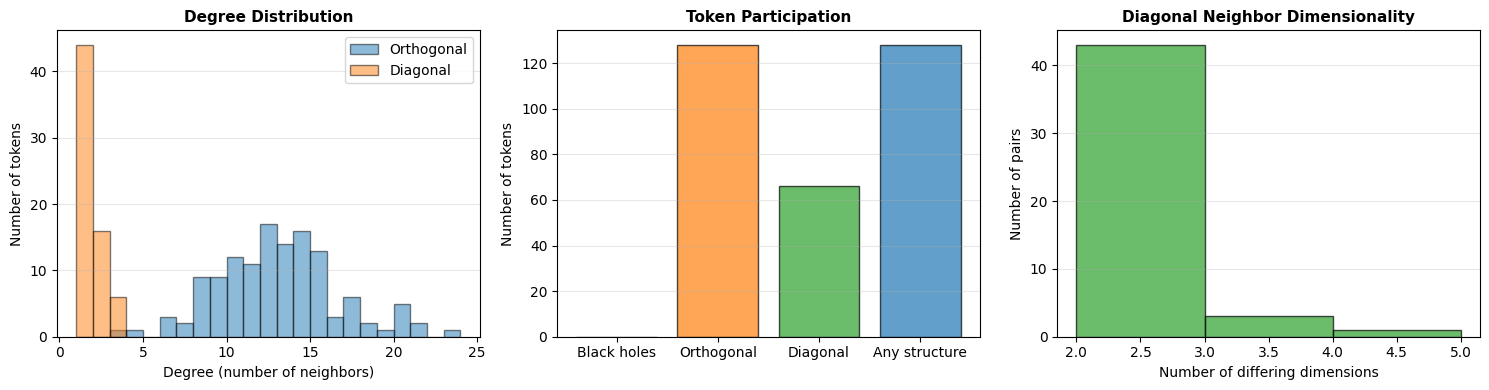

✓ Visualization complete


In [32]:
if len(all_structured_tokens) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=100)
    
    # Plot 1: Degree distributions
    ax = axes[0]
    if len(black_hole_degrees) > 0:
        degrees = list(black_hole_degrees.values())
        ax.hist(degrees, bins=range(1, max(degrees)+2), alpha=0.5, label='Black holes', edgecolor='black')
    if len(orthogonal_degrees) > 0:
        degrees = list(orthogonal_degrees.values())
        ax.hist(degrees, bins=range(1, max(degrees)+2), alpha=0.5, label='Orthogonal', edgecolor='black')
    if len(diagonal_degrees) > 0:
        degrees = list(diagonal_degrees.values())
        ax.hist(degrees, bins=range(1, min(max(degrees)+2, 50)), alpha=0.5, label='Diagonal', edgecolor='black')
    ax.set_xlabel('Degree (number of neighbors)', fontsize=10)
    ax.set_ylabel('Number of tokens', fontsize=10)
    ax.set_title('Degree Distribution', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 2: Token participation
    ax = axes[1]
    categories = ['Black holes', 'Orthogonal', 'Diagonal', 'Any structure']
    counts = [len(black_hole_tokens), len(orthogonal_tokens), len(diagonal_tokens), len(all_structured_tokens)]
    colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
    ax.bar(categories, counts, color=colors, edgecolor='black', alpha=0.7)
    ax.set_ylabel('Number of tokens', fontsize=10)
    ax.set_title('Token Participation', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Plot 3: Diagonal dimensionality
    ax = axes[2]
    if len(diagonal_pairs) > 0:
        n_dims_values = [n_dims for _, _, n_dims in diagonal_pairs]
        max_dims = min(max(n_dims_values), 30)
        ax.hist(n_dims_values, bins=range(2, max_dims + 2), edgecolor='black', alpha=0.7, color='#2ca02c')
        ax.set_xlabel('Number of differing dimensions', fontsize=10)
        ax.set_ylabel('Number of pairs', fontsize=10)
        ax.set_title('Diagonal Neighbor Dimensionality', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No diagonal neighbors', ha='center', va='center', fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")
else:
    print("(Skipping visualization: no structure found)")